# Ex 1

În documentaţia pgmpy găsiţi formularea şi implementarea celebrei probleme Monty Hall. Cerinţa acestui exerciţiu
este să explicaţi problema şi codul din implementare.

**Cerinta problemei**:

Suppose you’re on a game show, and you’re given the choice of three doors: Behind one door is a car; behind the others, goats. You pick a door, say No. 1, and the host, who knows what’s behind the doors, opens another door, say No. 3, which has a goat. He then says to you, “Do you want to pick door No. 2?” Is it to your advantage to switch your choice?

By intution it seems that there shouldn’t be any benefit of switching the door. But using Bayes’ Theorem we can show that by switching the door the contestant has more chances of winning.

**Explicarea problemei:**

Spre exemplu, daca concurentul alege prima data o usa (vom considera ca alege usa 1, ca in enuntul problemei), exista o probabilitate de 1/3 ca premiul sa fie in spatele usii alese (usa 1), si o probabilitate de de 2/3 ca premiul sa fie in spatele uneia dintre celelalte 2 usi (usa 2 sau 3).

Atfel, atunci cand gazda emisiunii deschide usa 3 si arata ca este o capra, nu se schimba faptul ca probabilitatea initiala a fost de 1/3 pentru usa aleasa de participant (usa 1) si de 2/3 pentru celelalte 2 usi combinate. De fapt, deschiderea usii 3 *redistribuie intreaga probabilitate de 2/3 catre singura usa ramasa (usa 2). De aceea, probabilitatea ca premiul sa fie in spatele usii 2 devine 2/3 daca schimbi usa.

Acest lucru este usor de observat din interpretatea probabilista a problemei, descrisa in documentatie astfel:

Consideram 3 variabile random, concurentul C ∈ {1, 2, 3}, hostul H ∈ {1, 2, 3}, premiul P ∈ {1, 2, 3}. Premiul a fost pus random in spatele uneia dintre usi, deci avem  P(P=1) = P(P=2) = P(P=3) = 1/3. Concurentul va alege randomuna dintre usi, deci avem P(C=1) = P(C=2) = P(C=3) = 1/3.

Vom avea astfel urmatoarele probabilitati (ce constituie de fapt si baza rationamentului nostru):

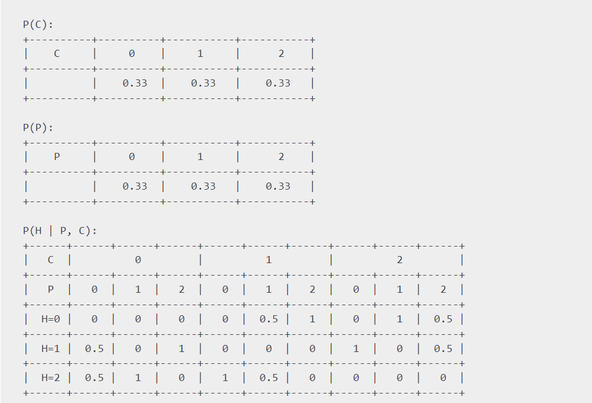


Primele 2 tabele reprezinta distributia probabilitatii variabilei C, respectiv P, iar ultimul tabel reprezinta probabilitatea ca gazda sa H sa deschida o anumita usa, tinand cont de usa aleaasa de concurentul C si usa in spatele careia se afla premiul P.

Se observa din al 3-lea tabel ca:

1. Daca gazda alege o usa, usa trebuie sa contina o capra, iar probabilitatile reflecta aceasta conditie

2. Daca concurentul a ales o usa diferita cea cu premiul, gazda va deschide intotdeauna usa ramasa cu o capra, cu probabilitate 1 (vezi coloana C=0, P=1)

3. In cazul in care sunt 2 usi ramase cu capre (atunci cand concurentul alege usa cu premiul), gazda alege intre cele 2 usi cu probabilitait egale (vezi coloana C=0, P=0)

Astfel se observa de ce probabilitatea de castig a concurentului creste daca acesta schimba usa aleasa cu cea ramasa dupa ce gazda numeste alege usa ce are o capra.

**Explicarea codului din implementare**



In [ ]:
!pip install pgmpy

In [ ]:
from pgmpy.models import BayesianNetwork      ## pentru a defini si construi reteaua bayesiana
from pgmpy.factors.discrete import TabularCPD    ## pentru a defini distribuitiile conditionale (CPD = Conditional Probability Distribution)


model = BayesianNetwork([("C", "H"), ("P", "H")])   ## definire structura retea bayesiana:
                                                    ## arcele din retea, ("C", "H") si ("P", "H") arata ca usa pe care o deschide H
                                                    ## depinde atat de usa deschisa de C, cat si de usa dupa care e premiul, P

## definirea celor 3 tabele cu probabilitati din imaginea de mai sus

cpd_c = TabularCPD("C", 3, [[0.33], [0.33], [0.33]])  ## tabelul pentru C
cpd_p = TabularCPD("P", 3, [[0.33], [0.33], [0.33]])  ## tabelul pentru P

cpd_h = TabularCPD(     ## tabelul pentru H unde:
    "H",
    3,
    [
        [0, 0, 0, 0, 0.5, 1, 0, 1, 0.5],
        [0.5, 0, 1, 0, 0, 0, 1, 0, 0.5],
        [0.5, 1, 0, 1, 0.5, 0, 0, 0, 0],
    ],
    evidence=["C", "P"],   ## probabilitatea de deschidee a unei usi depinde de valorile lui C si P
    evidence_card=[3, 3],   ## C si P pot avea 3 valori (pentru cele 3 usi)
)


## adaugarea CPD urilor definite anterior la retea => am definit complet reteaua bayesiana

model.add_cpds(cpd_c, cpd_p, cpd_h)


## verificarea modelului

model.get_cpds()   ## returneaza CPD-urile atasate modelului
model.check_model()    ## verifica daca structura retelei si CPD urile sunt corecte



## inferenta probabilitatilor conditionale

from pgmpy.inference import VariableElimination

infer = VariableElimination(model)   ## folosim algoritmul de eliminare a variabilelor pt a calcula probabilitatea conditionala,
                                     ## adica inferenta in reteaua bayesiana
posterior_p = infer.query(["P"], evidence={"C": 0, "H": 2})   ## exemplu: calculam probabilitatea ca premiul sa fie in spatele unei usi
                                                              ## daca concurentul a ales usa 0 si gazda a deschis usa 2

print(posterior_p)   ## afisare inferenta


+------+----------+
| P    |   phi(P) |
+======+==========+
| P(0) |   0.3333 |
+------+----------+
| P(1) |   0.6667 |
+------+----------+
| P(2) |   0.0000 |
+------+----------+


# Ex 2

Un medic doreşte să determine probabilitatea ca un pacient să aibă o anumită boală pulmonară (B), având în vedere
simptomele observate. Există trei variabile observabile care pot indica prezenţa bolii: tuse (T), dificultate de respiraţie
(D), radiografie anormală (X). Toate acestea sunt variabile binare.
De asemenea, ştim că:

● Dacă pacientul are boala (B), există o probabilitate ridicată să aibă tuse şi să apară anomalii la radiografie.

● Dificultatea de respiraţie (D) este dependentă atât de prezenţa bolii pulmonare (B), cât şi de prezenţa tusei (T).

Astfel, datele de probabilitate condiţionată sunt următoarele:

1. Probabilitatea apriori pentru boala pulmonară:

  P(B = 1) = 0.1, P(B = 0) = 0.9;

2. Probabilitatea condiţionată pentru tuse (T) condiţionată de boală (B):

  P(T = 1∣B = 1) = 0.8, P(T = 1∣B = 0) = 0.3;
  
3. Probabilitatea condiţionată pentru radiografie anormală (X) condiţionată de boală (B):

  P(X = 1∣B = 1) = 0.9, P(X = 1∣B = 0) = 0.1;

4. Probabilitatea condiţionată pentru dificultate de respiraţie (D), condiţionată de boală (B) şi tuse (T):

  P(D = 1∣B = 1,T = 1) = 0.9, P(D = 1∣B = 1,T = 0) = 0.4;

  P(D = 1∣B = 0,T = 1) = 0.5, P(D = 1∣B = 0,T = 0) = 0.1.


1) Definiti modelul probabilist, folosind pgmpy, care sa descrie contextul de mai sus.

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianNetwork([  # definire structura retea bayesiana
    ('B', 'T'),  # Boala afectează Tusea
    ('B', 'X'),  # Boala afectează Radiografia
    ('B', 'D'),  # Boala afectează Dificultatea de Respirație
    ('T', 'D')   # Tusea afectează Dificultatea de Respirație
])


# definirea tabelelor de probabilitati conditionate (CPT)

cpd_B = TabularCPD(variable='B', variable_card=2, values=[[0.9], [0.1]])   # probabilitati apriori pentru boala pulmonara

cpd_T = TabularCPD(variable='T', variable_card=2,     # probabilități pentru tuse conditionate de boala
                   values=[[0.7, 0.2], [0.3, 0.8]],
                   evidence=['B'], evidence_card=[2])

cpd_X = TabularCPD(variable='X', variable_card=2,     # probabilitati pentru radiografie anormală conditionate de boala
                   values=[[0.9, 0.1], [0.1, 0.9]],
                   evidence=['B'], evidence_card=[2])

cpd_D = TabularCPD(variable='D', variable_card=2,     # probabilitati pentru dificultatea de respiratie conditionate de boală si tuse
                   values=[[0.9, 0.5, 0.6, 0.1], [0.1, 0.5, 0.4, 0.9]],
                   evidence=['B', 'T'], evidence_card=[2, 2])


# adaugarea CPD urilor definite anterior la retea => am definit complet reteaua bayesiana
model.add_cpds(cpd_B, cpd_T, cpd_X, cpd_D)

# verificare model
assert model.check_model(), "Modelul nu este valid!"

# inferenta cu VariableElimination
inference = VariableElimination(model)



2) Medicul observă că pacientul are tuse şi dificultăţi de respiraţie. Determinaţi probabilitatea ca pacientul să aibă
boala pulmonară.

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianNetwork([  # definire structura retea bayesiana
    ('B', 'T'),  # Boala afectează Tusea
    ('B', 'X'),  # Boala afectează Radiografia
    ('B', 'D'),  # Boala afectează Dificultatea de Respirație
    ('T', 'D')   # Tusea afectează Dificultatea de Respirație
])


# definirea tabelelor de probabilitati conditionate (CPT)

cpd_B = TabularCPD(variable='B', variable_card=2, values=[[0.9], [0.1]])   # probabilitati apriori pentru boala pulmonara

cpd_T = TabularCPD(variable='T', variable_card=2,     # probabilități pentru tuse conditionate de boala
                   values=[[0.7, 0.2], [0.3, 0.8]],
                   evidence=['B'], evidence_card=[2])

cpd_X = TabularCPD(variable='X', variable_card=2,     # probabilitati pentru radiografie anormală conditionate de boala
                   values=[[0.9, 0.1], [0.1, 0.9]],
                   evidence=['B'], evidence_card=[2])

cpd_D = TabularCPD(variable='D', variable_card=2,     # probabilitati pentru dificultatea de respiratie conditionate de boală si tuse
                   values=[[0.9, 0.5, 0.6, 0.1], [0.1, 0.5, 0.4, 0.9]],
                   evidence=['B', 'T'], evidence_card=[2, 2])


# adaugarea CPD urilor definite anterior la retea => am definit complet reteaua bayesiana
model.add_cpds(cpd_B, cpd_T, cpd_X, cpd_D)

# verificare model
assert model.check_model(), "Modelul nu este valid!"

# inferenta cu VariableElimination
inference = VariableElimination(model)



prob_b_given_td = inference.query(variables=['B'], evidence={'T': 1, 'D': 1})  # probabilitate boala daca pacientul are tuse si dificultati de respiratie
print(prob_b_given_td)


+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.6522 |
+------+----------+
| B(1) |   0.3478 |
+------+----------+


3) Ulterior se descoperă (cu alte mijloace) că pacientul nu avea boala pulmonară. Care este probabilitatea ca radiografia să fi fost anormală?

In [ ]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

model = BayesianNetwork([  # definire structura retea bayesiana
    ('B', 'T'),  # Boala afectează Tusea
    ('B', 'X'),  # Boala afectează Radiografia
    ('B', 'D'),  # Boala afectează Dificultatea de Respirație
    ('T', 'D')   # Tusea afectează Dificultatea de Respirație
])


# definirea tabelelor de probabilitati conditionate (CPT)

cpd_B = TabularCPD(variable='B', variable_card=2, values=[[0.9], [0.1]])   # probabilitati apriori pentru boala pulmonara

cpd_T = TabularCPD(variable='T', variable_card=2,     # probabilități pentru tuse conditionate de boala
                   values=[[0.7, 0.2], [0.3, 0.8]],
                   evidence=['B'], evidence_card=[2])

cpd_X = TabularCPD(variable='X', variable_card=2,     # probabilitati pentru radiografie anormală conditionate de boala
                   values=[[0.9, 0.1], [0.1, 0.9]],
                   evidence=['B'], evidence_card=[2])

cpd_D = TabularCPD(variable='D', variable_card=2,     # probabilitati pentru dificultatea de respiratie conditionate de boală si tuse
                   values=[[0.9, 0.5, 0.6, 0.1], [0.1, 0.5, 0.4, 0.9]],
                   evidence=['B', 'T'], evidence_card=[2, 2])


# adaugarea CPD urilor definite anterior la retea => am definit complet reteaua bayesiana
model.add_cpds(cpd_B, cpd_T, cpd_X, cpd_D)

# verificare model
assert model.check_model(), "Modelul nu este valid!"

# inferenta cu VariableElimination
inference = VariableElimination(model)



prob_x_given_b0 = inference.query(variables=['X'], evidence={'B': 0})  # probabilitate radiografie anormala daca pacientul nu are boala
print(prob_x_given_b0)


+------+----------+
| X    |   phi(X) |
+======+==========+
| X(0) |   0.9000 |
+------+----------+
| X(1) |   0.1000 |
+------+----------+


4) **Bonus**: Calculaţi cele 2 probabilităţi folosind regula lui Bayes şi incărcaţi calculul fie în Markdown/Latex, fie ca foto
la foia de lucru (indicaţie: puteţi să vă folosiţi de independenţele condiţionale rezultate din modelul de reţea bayesiană)

**Calcul prima probabilitate**

Probabilitatea ca pacientul sa aiba boala pulmonara (folosind regula lui Bayes):

$$ P(B = 1 | T = 1, D = 1) = \frac{P(T = 1, D = 1 | B = 1) P(B = 1)}{P(T = 1, D = 1)} $$

$$ = \frac{P(T = 1 | B = 1) P(D = 1 | B = 1, T = 1) P(B = 1)}{P(T = 1, D = 1 | B = 1) P(B = 1) + P(T = 1, D = 1 | B = 0) P(B = 0)} $$

$$ = \frac{P(T = 1 | B = 1) P(D = 1 | B = 1, T = 1) P(B = 1)}{P(T = 1 | B = 1) P(D = 1 | B = 1, T = 1) P(B = 1) + P(T = 1 ∣ B = 0) P(D = 1 ∣ B = 0, T = 1) P(B = 0)} $$

$$ = \frac{0.8 \times 0.9 \times 0.1}{0.8 \times 0.9 \times 0.1 + 0.3 \times 0.5 \times 0.9} $$

$$ = \frac{0.8 \times 0.9 \times 0.1}{0.8 \times 0.9 \times 0.1 + 0.3 \times 0.5 \times 0.9} $$

$$ = \frac{0.072}{0.072 + 0.135} $$

$$ = \frac{0.072}{0.207} $$

$$ = 0.3478 $$

Am obtinut acelasi raspuns ca la algoritmul de la punctul 3)

**Calcul a doua probabilitate**

Probabilitatea ca pacientul sa aiba dificultate de respiratie cand nu are nicio boala se extrage direct din probabilitatile date:

$$ P(X = 1 | B = 0) = 0.1 $$

Aceeasi probabilitate se obtine si la algoritmul de la punctul 1)



   








# Ex 3

Un joc între doi jucători, J0 şi J1, se desfăşoară în felul următor:

* se aruncă mai întâi cu o monedam(normală) pentru a decide cine începe: J0 sau J1;

* în prima rundă, jucătorul desemnat aruncă cu propriul zar; fie n numărul obţinut;

* în a doua rundă, celălalt jucător aruncă cu moneda proprie de 2n ori; fie m numărul de steme obţinute.

Jucătorul din prima rundă câştigă dacă n ≥ m, în caz contrar câştigând jucătorul din a doua rundă. Mai ştim că
jucătorul J1 este necinstit, el aducând o monedă măsluită, cu probabilitatea de obţinere a stemei egală cu 4/7. În schimb, moneda jucătorului J0 este normală, iar cele două zaruri sunt şi ele normale.

1. Estimaţi care dintre cei doi jucători are şansele cele mai mari de câştig, simulând un joc de 10000 ori.

In [ ]:
import random

simulari = 10000

victorii_j0 = 0
victorii_j1 = 0


def arunca_moneda_normala():
    return random.choice([0, 1])

def arunca_moneda_masluita():
    return 1 if random.random() < 4/7 else 0

def arunca_zar():
    return random.randint(1, 6)



for _ in range(simulari):

    # decide primul jucator
    primul_jucator = arunca_moneda_normala()  # 0 = J0, 1 = J1

    # primul jucator ajunca zarul
    n = arunca_zar()

    # celalalt jucator arunca cu moneda de 2n ori
    if primul_jucator == 0:
        # daca J0 a inceput, J1 arunca moneda masluita
        m = sum(arunca_moneda_masluita() for _ in range(2 * n))
    else:
        # daca J1 a inceput, J0 arunca moneda normala
        m = sum(arunca_moneda_normala() for _ in range(2 * n))

    # comparam n cu m si decidem castigatorul
    if n >= m:
        if primul_jucator == 0:
            victorii_j0 += 1
        else:
            victorii_j1 += 1
    else:
        if primul_jucator == 0:
            victorii_j1 += 1
        else:
            victorii_j0 += 1



# sansele de castig pentru fiecare jucator
sanse_j0 = victorii_j0 / simulari
sanse_j1 = victorii_j1 / simulari

sanse_j0, sanse_j1


(0.4286, 0.5714)

2. Folosind pgmpy, definiţi o reţea Bayesiană care sa descrie contextul de mai sus.

In [ ]:
import math
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np

model = BayesianNetwork([
    ('CineIncepe', 'Zar'),
    ('Zar', 'NumarSteme_J0'),
    ('Zar', 'NumarSteme_J1'),
    ('NumarSteme_J0', 'Castigator'),
    ('NumarSteme_J1', 'Castigator')
])



cpd_cine_incepe = TabularCPD(variable='CineIncepe', variable_card=2, values=[[0.5], [0.5]])


cpd_zar = TabularCPD(variable='Zar', variable_card=6,
                     values=[[1/6, 1/6], [1/6, 1/6], [1/6, 1/6],
                             [1/6, 1/6], [1/6, 1/6], [1/6, 1/6]],
                     evidence=['CineIncepe'], evidence_card=[2])


# CPD pt nr steme J0 (monedă normală, 50% șansă de stemă)
values_j0 = []
for n in range(1, 7):  # 2n aruncări
    probs = [math.comb(2*n, k) * (0.5**k) * (0.5**(2*n-k)) for k in range(2*n + 1)]
    # completam cu 0-uri pentru a ajunge la 13 elemente
    probs.extend([0] * (13 - len(probs)))
    values_j0.append(probs)
values_j0 = np.array(values_j0).T  # transpunem pentru formatul corect

cpd_numar_steme_j0 = TabularCPD(variable='NumarSteme_J0', variable_card=13,
                                values=values_j0, evidence=['Zar'], evidence_card=[6])


# CPD pt nr steme J1 (moneda masluita, 4/7 sansa de stema)
values_j1 = []
for n in range(1, 7):  # 2n aruncări
    probs = [math.comb(2*n, k) * (4/7)**k * (3/7)**(2*n-k) for k in range(2*n + 1)]
    # completam cu 0-uri pentru a ajunge la 13 elemente
    probs.extend([0] * (13 - len(probs)))
    values_j1.append(probs)
values_j1 = np.array(values_j1).T  # transpunem pentru formatul corect

cpd_numar_steme_j1 = TabularCPD(variable='NumarSteme_J1', variable_card=13,
                                values=values_j1, evidence=['Zar'], evidence_card=[6])

# CPD pentru castigator
values = []
for j0 in range(13):
    for j1 in range(13):
        if j0 >= j1:
            values.append([1, 0])  # J0 castiga
        else:
            values.append([0, 1])  # J1 castiga

values = np.array(values).T

cpd_castigator = TabularCPD(variable='Castigator', variable_card=2,
                            values=values, evidence=['NumarSteme_J0', 'NumarSteme_J1'],
                            evidence_card=[13, 13])



# adaugam CPD-urile în model
model.add_cpds(cpd_cine_incepe, cpd_zar, cpd_numar_steme_j0, cpd_numar_steme_j1, cpd_castigator)

# verificam daca modelul e corect
assert model.check_model()

# inferente cu VariableElimination
inference = VariableElimination(model)

# calculam probabilitatea ca J0 sau J1 sa castige
result = inference.map_query(variables=['Castigator'])
print(result)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'Castigator': 0}


3. Folosind modelul de mai sus, determinaţi cine e cel mai probabil să fi început jocul, ştiind că în a doua rundă s-a
obţinut o singură stemă.

In [ ]:
import math
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
import numpy as np

model = BayesianNetwork([
    ('CineIncepe', 'Zar'),
    ('Zar', 'NumarSteme_J0'),
    ('Zar', 'NumarSteme_J1'),
    ('NumarSteme_J0', 'Castigator'),
    ('NumarSteme_J1', 'Castigator')
])



cpd_cine_incepe = TabularCPD(variable='CineIncepe', variable_card=2, values=[[0.5], [0.5]])


cpd_zar = TabularCPD(variable='Zar', variable_card=6,
                     values=[[1/6, 1/6], [1/6, 1/6], [1/6, 1/6],
                             [1/6, 1/6], [1/6, 1/6], [1/6, 1/6]],
                     evidence=['CineIncepe'], evidence_card=[2])


# CPD pt nr steme J0 (monedă normală, 50% șansă de stemă)
values_j0 = []
for n in range(1, 7):  # 2n aruncări
    probs = [math.comb(2*n, k) * (0.5**k) * (0.5**(2*n-k)) for k in range(2*n + 1)]
    # completam cu 0-uri pentru a ajunge la 13 elemente
    probs.extend([0] * (13 - len(probs)))
    values_j0.append(probs)
values_j0 = np.array(values_j0).T  # transpunem pentru formatul corect

cpd_numar_steme_j0 = TabularCPD(variable='NumarSteme_J0', variable_card=13,
                                values=values_j0, evidence=['Zar'], evidence_card=[6])


# CPD pt nr steme J1 (moneda masluita, 4/7 sansa de stema)
values_j1 = []
for n in range(1, 7):  # 2n aruncări
    probs = [math.comb(2*n, k) * (4/7)**k * (3/7)**(2*n-k) for k in range(2*n + 1)]
    # completam cu 0-uri pentru a ajunge la 13 elemente
    probs.extend([0] * (13 - len(probs)))
    values_j1.append(probs)
values_j1 = np.array(values_j1).T  # transpunem pentru formatul corect

cpd_numar_steme_j1 = TabularCPD(variable='NumarSteme_J1', variable_card=13,
                                values=values_j1, evidence=['Zar'], evidence_card=[6])

# CPD pentru castigator
values = []
for j0 in range(13):
    for j1 in range(13):
        if j0 >= j1:
            values.append([1, 0])  # J0 castiga
        else:
            values.append([0, 1])  # J1 castiga

values = np.array(values).T

cpd_castigator = TabularCPD(variable='Castigator', variable_card=2,
                            values=values, evidence=['NumarSteme_J0', 'NumarSteme_J1'],
                            evidence_card=[13, 13])




# adaugam CPD-urile in model
model.add_cpds(cpd_cine_incepe, cpd_zar, cpd_numar_steme_j0, cpd_numar_steme_j1, cpd_castigator)

# verificam daca modelul e corect
assert model.check_model()

# inferente cu VariableElimination
inference = VariableElimination(model)

# calculam probabilitatea ca J0 sau J1 sa fi inceput jocul, dat fiind ca s-a obtinut o singura stema
result = inference.map_query(variables=['CineIncepe'], evidence={'NumarSteme_J0': 1, 'NumarSteme_J1': 1})
print(result)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'CineIncepe': 0}
